## Channel Estimation

In [1]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from sklearn.metrics import mean_absolute_error, mean_squared_error
import commpy as cp

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [57]:
def generate_channel_estimation_dataset(dataset_size, preamble_length, constellations):
    QAMModem = cp.modulation.QAMModem(constellations)
    
    # use the constellation object to modulate the data bits into complex numbers
    
    preamble_bits = []
    preamble_bits_convolved = [] 
    preambles_constellations = []
    input_data_constellations = []
    convolved_preambles = []
    convolved_data_constellations = []
    channels = []
    least_squares_preambles = []
    least_squares_preambles_convolved = []
    
    for i in range(dataset_size):
       
        preambles = np.random.randint(0, 2, preamble_length)
        preamble_bits.append(preambles)
        
        
        preambles_constellation =  QAMModem.modulate(preambles)
        least_squares_preambles.append(preambles_constellation)

        
        real_preambles = np.real(preambles_constellation)
        im_preambles = np.imag(preambles_constellation)
        real_im_preambles = np.vstack((real_preambles,im_preambles)).reshape((-1,),order='F')
        preambles_constellations.append(real_im_preambles)
        channel_taps = [0, 0]
        channel_taps[0] = np.random.uniform(-1, 1)
        channel_taps[1] = np.random.uniform(-1, 1)
        channel_taps = channel_taps / np.linalg.norm(channel_taps)
        channels.append(channel_taps)
        preamble_bits_convolved.append(sig.convolve(preambles, channel_taps, mode='same'))
        
        
        preamble_conv = sig.convolve(preambles_constellation, channel_taps, mode='same')
        least_squares_preambles_convolved.append(preamble_conv)
        
        real_preambles_conv = np.real(preamble_conv)
        im_preambles_conv = np.imag(preamble_conv)
        real_im_preambles_conv = np.vstack((real_preambles_conv,im_preambles_conv)).reshape((-1,),order='F')
        convolved_preambles.append(real_im_preambles_conv)
        
        
    X1 = np.hstack([preambles_constellations, np.array(convolved_preambles)])
    channels = np.array(channels)
#     plt.scatter(np.zeros(input_data_constellations.shape[1]), input_data_constellations[0])
#     plt.show()
    return X1, channels, np.array(least_squares_preambles, dtype='complex'), np.array(least_squares_preambles_convolved, dtype='complex')

In [62]:
def create_model(input_layer_dim, hidden_layer_dim, input_dim, output_dim):
    model = Sequential()
    model.add(Dense(input_layer_dim, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(hidden_layer_dim, activation='sigmoid'))
    model.add(Dense(output_dim, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [105]:
dataset_size = 50000
preamble_length = 100
QAM_scheme = 4
preamble_data, channels, lstsq_preambles, lstsq_preamble_convolved = generate_channel_estimation_dataset(dataset_size, preamble_length, QAM_scheme)
train_size = int(preamble_data.shape[0] * 0.8)
preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
channel_train, channel_test = channels[:train_size], channels[train_size:]
lstsq_preambles_test, lstsq_preambles_convolved_test = lstsq_preambles[train_size:], lstsq_preamble_convolved[train_size:]
# print(preamble_train.shape, preamble_test.shape)
# print(channel_train.shape, channel_test.shape)
# print(preamble_test, channel_test)


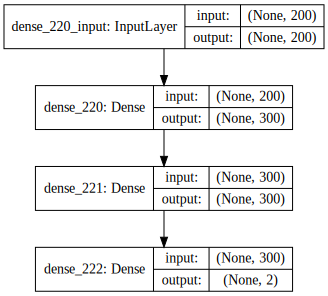

In [103]:
model = create_model(300, 300, preamble_train.shape[1], channel_train.shape[1])
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [104]:
def generate_topleitz(row_vector, channel_length):
    from scipy import linalg as la
    first_row = row_vector[:channel_length]
    first_col = row_vector
    return la.toeplitz(first_col, first_row)

def least_squares(A, b):
    return np.linalg.lstsq(A, b)[0]

def perform_least_squares(preamble, preamble_convolved, channel_length):
    A, b = generate_topleitz(preamble, channel_length), preamble_convolved
    prediction = least_squares(A, b)
    return np.array(prediction)

def run_least_squares_channel_est(preambles, preambles_convolved, channels):
    errors = []
    for preamble, preamble_convolved, channel in zip(preambles, preambles_convolved, channels):
        channel_estimate = np.real(perform_least_squares(preamble, preamble_convolved, channels.shape[1]))
        errors.append(mean_squared_error(channel, channel_estimate))
    return np.mean(np.array(errors))
        

error_lst_squares = run_least_squares_channel_est(lstsq_preambles, lstsq_preamble_convolved, channels)
print(error_lst_squares)
# print(predictions_least_squares)
# print(channel_test)
# mse = mean_squared_error(predictions_least_squares, channel_test)
# mabse = mean_absolute_error(predictions_least_squares, channel_test)
# print('Mean Squared Error: {0}'.format(mse))
# print('Mean Absolute Error: {0}'.format(mabse))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


0.00015076780306240052


In [108]:
def run_channel_estimation_experiment():
    preamble_lengths = range(20, 201, 20)
    errors = []
    lstsq_errors = []
    for preamble_length in preamble_lengths:
        print('Preamble length:', preamble_length)
        preamble_data, channels, lstsq_preambles, lstsq_preamble_convolved = generate_channel_estimation_dataset(50000, preamble_length, 4)
        print('Generated data')
        train_size = int(preamble_data.shape[0] * 0.8)
        preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
        channel_train, channel_test = channels[:train_size], channels[train_size:]
        lstsq_preambles_test, lstsq_preambles_convolved_test = lstsq_preambles[train_size:], lstsq_preamble_convolved[train_size:]
        model = create_model(300, 300, preamble_train.shape[1], channel_train.shape[1])
        history = model.fit(preamble_train, channel_train, validation_data=(preamble_test, channel_test), epochs=100, batch_size=64, verbose=0)
        error = history.history['val_loss'][-1]
        errors.append(error)
        print('Error NN:', error)
        
        error_lst_squares = run_least_squares_channel_est(lstsq_preambles_test, lstsq_preambles_convolved_test, channel_test)
        print('Error LSTSQ:', error_lst_squares)
        lstsq_errors.append(error_lst_squares)
        
    return preamble_lengths, errors, lstsq_errors

preamble_lengths, errors, lstsq_errors = run_channel_estimation_experiment()

Preamble length: 20
Generated data
Error NN: 4.754407906439155e-05


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Error LSTSQ: 3.3957018369530616e+25
Preamble length: 40
Generated data
Error NN: 0.004040335788577795
Error LSTSQ: 0.000941029412518733
Preamble length: 60
Generated data
Error NN: 0.004707991209626197
Error LSTSQ: 0.00042014736153357814
Preamble length: 80
Generated data
Error NN: 0.009021696710586547
Error LSTSQ: 0.00023331364400975817
Preamble length: 100
Generated data
Error NN: 0.013438218662142754
Error LSTSQ: 0.00014950728863363872
Preamble length: 120
Generated data
Error NN: 0.017218790954351425
Error LSTSQ: 0.00010475193447906265
Preamble length: 140
Generated data
Error NN: 0.016708977895975113
Error LSTSQ: 7.696480009499078e-05
Preamble length: 160
Generated data
Error NN: 0.020766299739480017
Error LSTSQ: 5.82460430679427e-05
Preamble length: 180
Generated data
Error NN: 0.022629045289754866
Error LSTSQ: 4.650191001231202e-05
Preamble length: 200
Generated data
Error NN: 0.026092957919836044
Error LSTSQ: 3.7764953412524425e-05


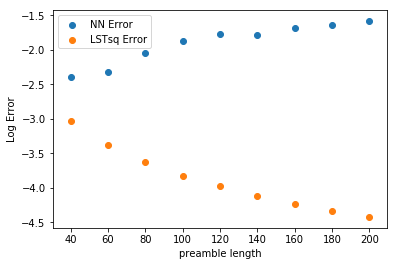

In [115]:
preamble_lengths = list(range(40, 201, 20))
plt.scatter(preamble_lengths, np.log10(errors[1:]), label='NN Error')
plt.scatter(preamble_lengths, np.log10(lstsq_errors[1:]), label='LSTsq Error')
plt.xlabel('preamble length')
plt.ylabel('Log Error')
plt.legend()
plt.show()

## One Tap Channel Inversion (Division)

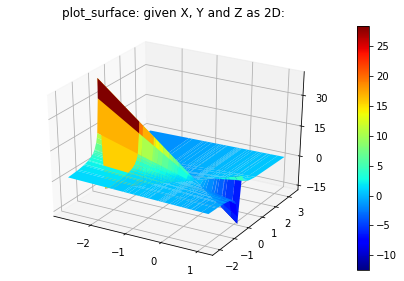

In [49]:
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy
from numpy.random import randn, shuffle
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape


# =========================
## generating ordered data:

N = 32
x = sorted(randn(N))
y = sorted(randn(N))

X, Y = meshgrid(x, y)
Z = X / Y


# ======================================
## reference picture (X, Y and Z in 2D):

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

title = ax.set_title("plot_surface: given X, Y and Z as 2D:")
title.set_y(1.01)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

In [70]:
def create_channel_inverse_model():
    model_inverse = Sequential()
    model_inverse.add(Dense(2, input_shape=(2,)))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(1, activation='linear'))
    model_inverse.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
    return model_inverse

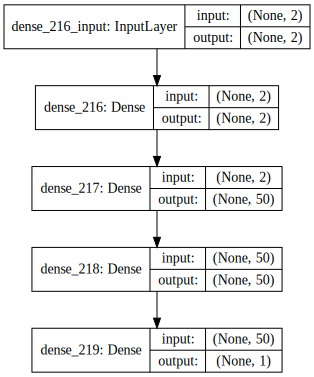

In [102]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
model_inverse = create_channel_inverse_model()
SVG(model_to_dot(model_inverse, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [76]:
def generate_one_tap_channel_inversion_data(dataset_size, channel_lower_bound):
    data_X = []
    Y = []
    for i in range(dataset_size):
        data = np.random.uniform(-1, 1)
        channel = np.random.uniform(channel_lower_bound, 1)
        data_X.append([data, channel])
        Y.append(data / channel)

    X, Y = np.array(data_X), np.array(Y)
    train_size = int(0.8 * dataset_size)
    X_train, Y_train, X_test, Y_test = X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]
    return X_train, Y_train, X_test, Y_test



In [77]:
def run_varying_channel_lower_bound_experiment():
    lower_bounds = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    errors = []
    for channel_lower_bound in lower_bounds:
        avg_error = []
        print(channel_lower_bound)
        for trial in range(5):
            print(trial)
            X_train, Y_train, X_test, Y_test = generate_one_tap_channel_inversion_data(10000, channel_lower_bound)
            model_inverse = create_channel_inverse_model()
            history = model_inverse.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=0)
            error = history.history['val_loss'][-1]
            avg_error.append(error)
        errors.append(sum(avg_error) / 5)
    return lower_bounds, errors


lower_bounds, errors = run_varying_channel_lower_bound_experiment()        
print(lower_bounds)
print(errors)

0
0
1
2
3
4
0.01
0
1
2
3
4
0.05
0
1
2
3
4
0.1
0
1
2
3
4
0.2
0
1
2
3
4
0.3
0
1
2
3
4
0.4
0
1
2
3
4
0.5
0
1
2
3
4
[0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[4220.708897505438, 1.2571276032953524, 0.0029150321228429673, 0.00042879482945427304, 6.490642346034293e-05, 4.962954599759541e-05, 6.527368150418625e-05, 0.00029157309302827345]


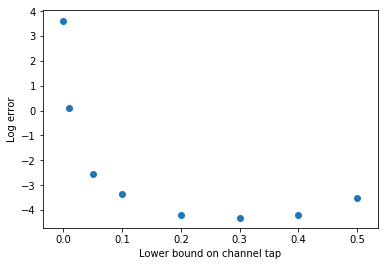

In [79]:
plt.scatter(lower_bounds, np.log10(errors))
plt.xlabel('Lower bound on channel tap')
plt.ylabel('Log error')
plt.show()

In [79]:
def create_channel_inverse_model():
    model_inverse = Sequential()
    model_inverse.add(Dense(2, input_shape=(2,)))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(1, activation='linear'))
    model_inverse.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
    return model_inverse

def generate_channel_inversion_one_tap_log_features(dataset_size, channel_lower_bound):
    data_X = []
    Y = []
    for i in range(dataset_size):
        data = np.random.uniform(0.1, 1)
        channel = np.random.uniform(channel_lower_bound, 1)
        data_X.append([data, channel])
        Y.append(data / channel)

    X, Y = np.log(np.array(data_X)), np.log(np.array(Y))

    train_size = int(0.8 * dataset_size)
    X_train, Y_train, X_test, Y_test = X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]
    return X_train, Y_train, X_test, Y_test

def run_varying_channel_lower_bound_experiment_log_features():
    lower_bounds = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    errors = []
    for channel_lower_bound in lower_bounds:
        avg_error = []
        print(channel_lower_bound)
        for trial in range(5):
            print(trial)
            X_train, Y_train, X_test, Y_test = generate_channel_inversion_one_tap_log_features(10000, channel_lower_bound)
            model_inverse = create_channel_inverse_model_log()
            history = model_inverse.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=0)
            error = history.history['val_loss'][-1]
            print('Error: {0}'.format(error))
            avg_error.append(error)
        errors.append(sum(avg_error) / 5)
    return lower_bounds, errors

lower_bounds, errors = run_varying_channel_lower_bound_experiment_log_features()  

0
0
Error: 4.957385820207258e-14
1
Error: 1.5276960930012475e-14
2
Error: 8.537100995749392e-14
3
Error: 3.229858010308817e-05
4
Error: 1.9588047412980815e-05
0.01
0
Error: 1.5806054002535236e-14
1
Error: 5.686233817137065e-12
2
Error: 3.1305491011990317e-13
3
Error: 1.4746391524544932e-11
4
Error: 6.314194186415989e-06
0.05
0
Error: 1.1757015771097362e-14
1
Error: 7.187668760177956e-11
2
Error: 6.913555557035155e-14
3
Error: 5.089352110854151e-10
4
Error: 1.8558657860490157e-11
0.1
0
Error: 1.1154165330089227e-13
1
Error: 2.506014559912728e-06
2
Error: 3.5123717961882404e-12
3
Error: 1.057217711775138e-08
4
Error: 9.312002368202024e-15
0.2
0
Error: 2.6473193700127933e-14
1
Error: 9.368030873604938e-15
2
Error: 1.2097627825717606e-13
3
Error: 4.964588344869015e-10
4
Error: 1.3766903972367573e-09
0.3
0
Error: 0.00012961585097946227
1
Error: 5.310332184291048e-15
2
Error: 9.536901256979036e-08
3
Error: 2.567167885717936e-05
4
Error: 1.1365786214750581e-14
0.4
0
Error: 8.655903142688882e-

<IPython.core.display.Javascript object>


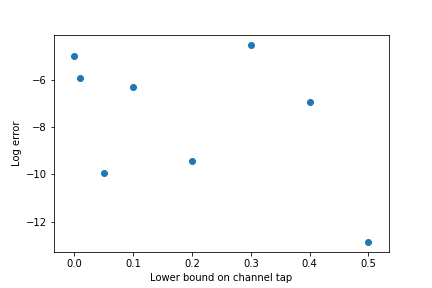

In [89]:
plt.scatter(lower_bounds, np.log10(errors))
plt.xlabel('Lower bound on channel tap')
plt.ylabel('Log error')
plt.show()

## Network for Multiplication

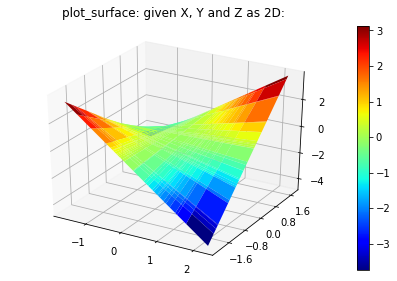

In [101]:
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy
from numpy.random import randn, shuffle
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape


# =========================
## generating ordered data:

N = 32
x = sorted(randn(N))
y = sorted(randn(N))

X, Y = meshgrid(x, y)
Z = X * Y


# ======================================
## reference picture (X, Y and Z in 2D):

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

title = ax.set_title("plot_surface: given X, Y and Z as 2D:")
title.set_y(1.01)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

fig.tight_layout()

In [81]:
def generate_data_for_multiplication(dataset_size):
    data_X = []
    Y = []
    for i in range(dataset_size):
        data = np.random.uniform(-1, 1)
        channel = np.random.uniform(10)
        data_X.append([data, channel])
        Y.append(data * channel)

    X, Y = np.array(data_X), np.array(Y)
    train_size = int(0.8 * dataset_size)
    X_train, Y_train, X_test, Y_test = X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]
    return X_train, Y_train, X_test, Y_test

In [82]:
def create_channel_multiplication_model():
    model_inverse = Sequential()
    model_inverse.add(Dense(2, input_shape=(2,)))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(50, activation='sigmoid'))
    model_inverse.add(Dense(1, activation='linear'))
    model_inverse.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
    return model_inverse

In [83]:
dataset_size = 50000
mul_X_train, mul_Y_train, mul_X_test, mul_Y_test = generate_data_for_multiplication(dataset_size)
model_mul = create_channel_multiplication_model()
history = model_mul.fit(mul_X_train, mul_Y_train, validation_data=(mul_X_test, mul_Y_test), epochs=100, batch_size=64)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s - loss: 6.3597 - mean_squared_error: 6.3597 - val_loss: 2.2795 - val_mean_squared_error: 2.2795
Epoch 2/100
40000/40000 [==============================] - 2s - loss: 1.4776 - mean_squared_error: 1.4776 - val_loss: 0.3397 - val_mean_squared_error: 0.3397
Epoch 3/100
40000/40000 [==============================] - 2s - loss: 0.1068 - mean_squared_error: 0.1068 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 4/100
40000/40000 [==============================] - 2s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 5/100
40000/40000 [==============================] - 2s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0268 - val_mean_squared_error: 0.0268
Epoch 6/100
40000/40000 [==============================] - 2s - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Ep

40000/40000 [==============================] - 2s - loss: 4.9332e-05 - mean_squared_error: 4.9332e-05 - val_loss: 1.5863e-05 - val_mean_squared_error: 1.5863e-05
Epoch 95/100
40000/40000 [==============================] - 2s - loss: 5.5022e-05 - mean_squared_error: 5.5022e-05 - val_loss: 1.1274e-04 - val_mean_squared_error: 1.1274e-04
Epoch 96/100
40000/40000 [==============================] - 2s - loss: 5.2879e-05 - mean_squared_error: 5.2879e-05 - val_loss: 2.2771e-05 - val_mean_squared_error: 2.2771e-05
Epoch 97/100
40000/40000 [==============================] - 2s - loss: 5.0156e-05 - mean_squared_error: 5.0156e-05 - val_loss: 9.3899e-05 - val_mean_squared_error: 9.3899e-05
Epoch 98/100
40000/40000 [==============================] - 2s - loss: 5.9109e-05 - mean_squared_error: 5.9109e-05 - val_loss: 1.1293e-05 - val_mean_squared_error: 1.1293e-05
Epoch 99/100
40000/40000 [==============================] - 2s - loss: 7.2916e-05 - mean_squared_error: 7.2916e-05 - val_loss: 1.8881e-05 

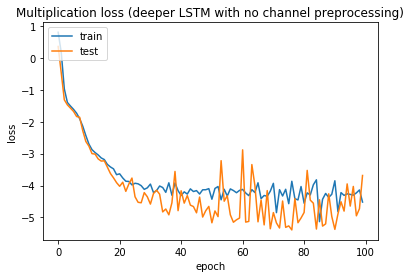

In [92]:
%matplotlib inline
plt.plot(np.log10(history.history['loss']))
plt.plot(np.log10(history.history['val_loss']))
plt.title('Multiplication loss (deeper LSTM with no channel preprocessing)') # change this title 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [95]:
def generate_data_for_multiplication_log(dataset_size):
    data_X = []
    Y = []
    for i in range(dataset_size):
        data = np.random.uniform(0.2, 1)
        channel = np.random.uniform(10)
        data_X.append([data, channel])
        Y.append(data * channel)

    X, Y = np.log10(np.array(data_X)), np.log10(np.array(Y))
    train_size = int(0.8 * dataset_size)
    X_train, Y_train, X_test, Y_test = X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]
    return X_train, Y_train, X_test, Y_test

def create_channel_multiplication_model_log():
    model_inverse = Sequential()
    model_inverse.add(Dense(2, input_shape=(2,)))
    model_inverse.add(Dense(50, activation='linear'))
    model_inverse.add(Dense(50, activation='linear'))
    model_inverse.add(Dense(1, activation='linear'))
    model_inverse.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
    return model_inverse

In [96]:
dataset_size = 50000
mul_X_train_log, mul_Y_train_log, mul_X_test_log, mul_Y_test_log = generate_data_for_multiplication_log(dataset_size)
model_mul = create_channel_multiplication_model_log()
history_log = model_mul.fit(mul_X_train_log, mul_Y_train_log, validation_data=(mul_X_test_log, mul_Y_test_log), epochs=100, batch_size=64)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.1528e-15 - val_mean_squared_error: 3.1528e-15
Epoch 2/100
40000/40000 [==============================] - 1s - loss: 3.2815e-15 - mean_squared_error: 3.2815e-15 - val_loss: 3.1452e-15 - val_mean_squared_error: 3.1452e-15
Epoch 3/100
40000/40000 [==============================] - 1s - loss: 3.3406e-15 - mean_squared_error: 3.3406e-15 - val_loss: 3.1004e-15 - val_mean_squared_error: 3.1004e-15
Epoch 4/100
40000/40000 [==============================] - 1s - loss: 3.4119e-15 - mean_squared_error: 3.4119e-15 - val_loss: 5.1045e-15 - val_mean_squared_error: 5.1045e-15
Epoch 5/100
40000/40000 [==============================] - 2s - loss: 4.0357e-15 - mean_squared_error: 4.0357e-15 - val_loss: 3.3508e-15 - val_mean_squared_error: 3.3508e-15
Epoch 6/100
40000/40000 [==============================] - 1s - loss: 4.2896e-05 - mean_

40000/40000 [==============================] - 2s - loss: 9.1855e-07 - mean_squared_error: 9.1855e-07 - val_loss: 2.3485e-15 - val_mean_squared_error: 2.3485e-15
Epoch 94/100
40000/40000 [==============================] - 2s - loss: 2.5537e-09 - mean_squared_error: 2.5537e-09 - val_loss: 4.7039e-07 - val_mean_squared_error: 4.7039e-07
Epoch 95/100
40000/40000 [==============================] - 2s - loss: 6.2186e-07 - mean_squared_error: 6.2186e-07 - val_loss: 1.5186e-12 - val_mean_squared_error: 1.5186e-12
Epoch 96/100
40000/40000 [==============================] - 1s - loss: 4.8432e-07 - mean_squared_error: 4.8432e-07 - val_loss: 1.4900e-13 - val_mean_squared_error: 1.4900e-13
Epoch 97/100
40000/40000 [==============================] - 1s - loss: 2.5483e-07 - mean_squared_error: 2.5483e-07 - val_loss: 1.7054e-11 - val_mean_squared_error: 1.7054e-11
Epoch 98/100
40000/40000 [==============================] - 2s - loss: 1.3202e-06 - mean_squared_error: 1.3202e-06 - val_loss: 1.9216e-15 

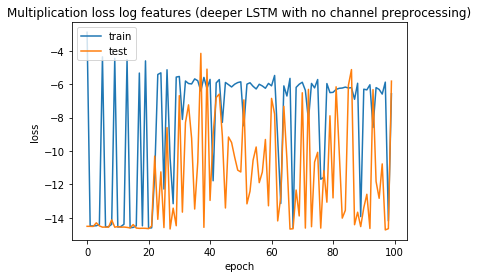

In [97]:
%matplotlib inline
plt.plot(np.log10(history_log.history['loss']))
plt.plot(np.log10(history_log.history['val_loss']))
plt.title('Multiplication loss log features (deeper LSTM with no channel preprocessing)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Equalization

In [116]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector

In [118]:
def qam_4_modulation(bitstring):
    modulated_symbol = []
    reshaped_bit_string = bitstring.reshape((len(bitstring) // 2 , 2))

    for row in reshaped_bit_string:
        if np.array_equal(row, np.array([0, 0])):
            modulated_symbol.append(1 + 1j)
        elif np.array_equal(row, np.array([1, 0])):
            modulated_symbol.append(-1 + 1j)
        elif np.array_equal(row, np.array([1, 1])):
            modulated_symbol.append(-1 - 1j)
        else:
            modulated_symbol.append(1 - 1j)
    return np.array(modulated_symbol)

def add_awgn_noise(signal,SNR_dB):
    """  Adds AWGN noise vector to signal 
         to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/20.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    
    return y.flatten()

In [119]:
def generate_combined_dataset_qam_4_edited(dataset_size,  preamble_length, data_length, channel_length, SNR, constellations):
#     QAMModem = cp.modulation.QAMModem(constellations)
    
    # use the constellation object to modulate the data bits into complex numbers
    
    
    preambles_constellations = []
    input_data_constellations = []
    convolved_preambles = []
    convolved_data_constellations = []
    channels = []
    
    for i in range(dataset_size):
        input_data_bits = np.random.randint(0, 2, data_length)
        preambles = np.random.randint(0, 2, preamble_length)
        
        input_data_constellation = qam_4_modulation(input_data_bits)
        real_input = np.real(input_data_constellation)
        im_input = np.imag(input_data_constellation)
        real_im_input = np.vstack((real_input,im_input)).T
        input_data_constellations.append(real_im_input)
        
        preambles_constellation =  qam_4_modulation(preambles)
        real_preambles = np.real(preambles_constellation)
        im_preambles = np.imag(preambles_constellation)
        real_im_preambles = np.vstack((real_preambles,im_preambles)).reshape((-1,),order='F')
        preambles_constellations.append(real_im_preambles)
        channel_taps = [0, 0]
        channel_taps[0] = np.random.uniform(-1, 1)
        channel_taps[1] = np.random.uniform(-1, 1)
        channel_taps = channel_taps / np.linalg.norm(channel_taps)
        channels.append(channel_taps)
        
        preamble_conv = sig.convolve(preambles_constellation, channel_taps, mode='same')
        real_preambles_conv = np.real(preamble_conv)
        im_preambles_conv = np.imag(preamble_conv)
        real_im_preambles_conv = np.vstack((real_preambles_conv,im_preambles_conv)).reshape((-1,),order='F')
        convolved_preambles.append(real_im_preambles_conv)
        
        constellation_convolved = add_awgn_noise(sig.convolve(input_data_constellation, channel_taps, mode='same'), SNR)
        real_constellation_conv = np.real(constellation_convolved)
        im_constellation_conv = np.imag(constellation_convolved)
        real_im_constellation_conv = np.vstack((real_constellation_conv,im_constellation_conv)).T
        convolved_data_constellations.append(real_im_constellation_conv)
        
    X1 = np.hstack([preambles_constellations, np.array(convolved_preambles)])
    X2 = np.array(convolved_data_constellations)
    Y = np.array(input_data_constellations)
    channels = np.array(channels)
#     plt.scatter(np.zeros(input_data_constellations.shape[1]), input_data_constellations[0])
#     plt.show()
    return X1, X2, Y, channels

In [120]:
def transform_data(channel_data, convolved_data, input_data_symbols, sequence_length, window_length=3):
    channels, convolved_data_features, input_data_symbols_target = [], [], []
    for i in range(convolved_data.shape[0]):
        data_sequence, input_symbols = convolved_data[i], input_data_symbols[i]
        channel = channel_data[i]
        for j in range(sequence_length - window_length + 1):
            convolved_data_features.append(data_sequence[j:j+window_length])
            input_data_symbols_target.append(input_symbols[j:j+window_length])
            channels.append(channel)
    #       print(i, j)
          
    return np.array(channels), np.array(convolved_data_features), np.array(input_data_symbols_target)

In [121]:
preamble_length = 80
data_length = 60
dataset_size = 5000
channel_length = 2
SNR = 10
QAM_scheme = 4
preamble_data, convolved_data, input_data_symbols, channels = generate_combined_dataset_qam_4_edited(dataset_size, preamble_length, data_length, channel_length, SNR, QAM_scheme)
channels, convolved_data, input_data_symbols = transform_data(channels, convolved_data, input_data_symbols, data_length // 2, 3)
train_size = int(input_data_symbols.shape[0] * 0.8)
preamble_train, preamble_test = preamble_data[:train_size], preamble_data[train_size:]
convolved_train, convolved_test = convolved_data[:train_size], convolved_data[train_size:]
input_data_symbols_train, input_data_symbols_test = input_data_symbols[:train_size], input_data_symbols[train_size:]
channel_train, channel_test = channels[:train_size], channels[train_size:]
# print(preamble_train.shape, preamble_test.shape)
print(convolved_train.shape, convolved_test.shape)
print(input_data_symbols_train.shape, input_data_symbols_test.shape)
print(channel_train.shape, channel_test.shape)

(112000, 3, 2) (28000, 3, 2)
(112000, 3, 2) (28000, 3, 2)
(112000, 2) (28000, 2)


In [122]:
def build_end_to_end_model_two_tap_channel_deeper_LSTM_no_preprocessing(preamble_length, data_length, channel_length, output_length):
    
    channel = Input(shape=(channel_length,))
    data = Input(shape=(data_length, 2))
    channel_repeated = RepeatVector(data_length)(channel)

    output = concatenate([data, channel_repeated])
    data_layers = Bidirectional(LSTM(90, return_sequences=True))(output)
    data_layers_2 = Bidirectional(LSTM(90, return_sequences=True))(data_layers)
    data_layers_3 = Bidirectional(LSTM(90, return_sequences=True))(data_layers_2)
    data_layers_4 = Bidirectional(LSTM(90, return_sequences=True))(data_layers_3)

    output_1 = TimeDistributed(Dense(100, activation='relu'))(data_layers_4)
    output_2 = TimeDistributed(Dense(100, activation='relu'))(output_1)
    output = TimeDistributed(Dense(2, activation='linear'))(output_1)
    model = Model(inputs=[channel, data], outputs=[output])

    model.compile(optimizer='adagrad', loss='mse', metrics=['mse'])
    return model

In [123]:
model4 = build_end_to_end_model_two_tap_channel_deeper_LSTM_no_preprocessing(channel_train.shape[1], convolved_train.shape[1], channel_length, input_data_symbols_train.shape[1])

In [124]:
history_model4 = model4.fit([channel_train, convolved_train], [input_data_symbols_train], validation_data=([channel_test, convolved_test], [input_data_symbols_test]), epochs=500, batch_size=1024)

Train on 112000 samples, validate on 28000 samples
Epoch 1/500


KeyboardInterrupt: 

In [125]:
plt.plot(np.log10(history_model4.history['loss']))
plt.plot(np.log10(history_model4.history['val_loss']))
plt.title('model4 loss (deeper LSTM with no channel preprocessing)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.xscale('log')
plt.show()

NameError: name 'history_model4' is not defined

In [ ]:
predictions4 = model4.predict([channel_test, convolved_test])

In [126]:
def calc_accuracy(original, predictions):
    return np.sum(original == predictions) / (original.shape[0] * original.shape[1])


In [ ]:
rounded_predictions4 = np.where(predictions4 > 0, 1, -1)
print(channel_test)
print(rounded_predictions4.shape)
# print(rounded_predictions4.shape, input_data_symbols_test.shape)
rounded_predictions_reshaped4 = rounded_predictions4.reshape((84000, 2))
test_data_reshaped4 = input_data_symbols_test.reshape((84000, 2))
calc_accuracy(rounded_predictions_reshaped4, test_data_reshaped4)

In [ ]:
error_channels = []
for i in range(rounded_predictions4.shape[0]):
    for j in range(3):
        if not np.array_equal(rounded_predictions4[i][j], input_data_symbols_test[i][j]):
            print('Channel', channel_test[i])
            print('Prediction', predictions4[i][j])
            print('QPSK Prediction', rounded_predictions4[i][j])
            print('True QPSK', input_data_symbols_test[i][j])
            error_channels.append(channel_test[i])

In [ ]:
## This plots which channels the RNN makes errors on
channel_errors = np.array(error_channels)
plt.title('Channels that the RNN makes Errors')
plt.xlabel('channel_X')
plt.ylabel('channel_Y')
plt.scatter(channel_errors[:, 0], channel_errors[:, 1])
plt.show()